# Descripción general de la red

Importar las librerias de networkx y wntr.

In [1]:
import networkx as nx
import wntr
import numpy as np
import matplotlib.pylab as plt

Importar el archivo de la red (*.inp) y se guarda en la variable 'wn'.

In [2]:
wn = wntr.network.WaterNetworkModel('nets/Chihuahua.inp')

Detalle de la red

In [3]:
wn.describe()

{'Nodes': 1327,
 'Links': 1570,
 'Patterns': 4,
 'Curves': 11,
 'Sources': 1,
 'Controls': 0}

# Mostramos la red

(<matplotlib.collections.PathCollection at 0x229d3beef40>,
 <matplotlib.collections.LineCollection at 0x229b1486100>)

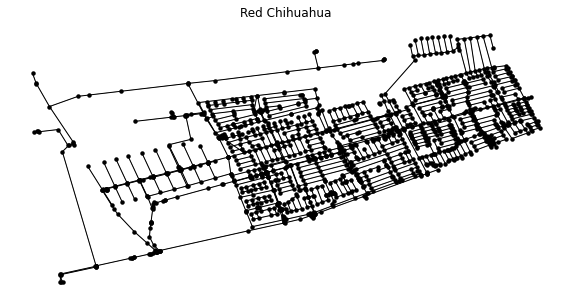

In [4]:
fig, (ax1) = plt.subplots(1, 1, figsize=(10,5))
wntr.graphics.plot_network(wn, node_size=20, title='Red Chihuahua',ax=ax1)

## Elevaciones

(<matplotlib.collections.PathCollection at 0x229d3aa4ac0>,
 <matplotlib.collections.LineCollection at 0x229d3bdcdc0>)

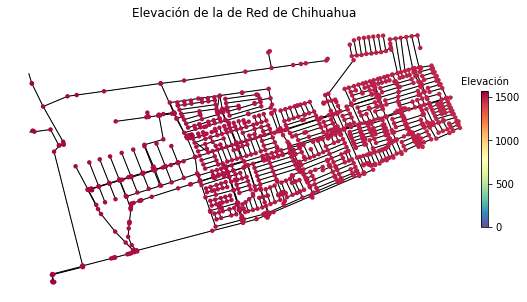

In [5]:
fig, (ax1) = plt.subplots(1, 1, figsize=(10,5))
wntr.graphics.plot_network(wn, title='Elevación de la de Red de Chihuahua', node_attribute='elevation', node_colorbar_label='Elevación',ax=ax1)

## Esqueletización

In [6]:
skel_wn = wntr.morph.skeletonize(wn, 12*0.0254)
skel_wn.describe()

{'Nodes': 539,
 'Links': 723,
 'Patterns': 4,
 'Curves': 11,
 'Sources': 1,
 'Controls': 0}

Mostramos la red esqueletizada

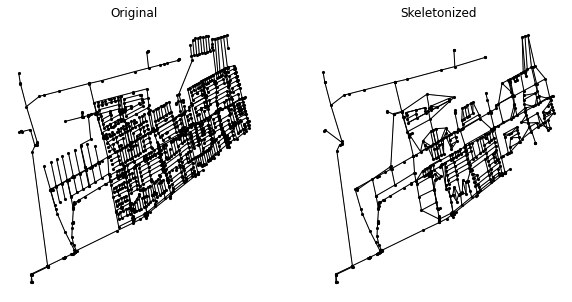

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
nodes, edges = wntr.graphics.plot_network(wn, node_size=10, title='Original', ax=ax1)
nodes, edges = wntr.graphics.plot_network(skel_wn, node_size=10,title='Skeletonized', ax=ax2)

# Parametros topologicos de Red
## Densidad de enlaces

Para aplicar las métricas de resiliencia topográficas requieren que la red ejemplo sea un grafo simple y no dirigido.
La variable 'wn' se convierte en un multigrafo dirigido representado con la variable 'G', posteriormente se utiliza para transformarla en un multigrafo no dirigido que se representa con la variable 'uG', por último esta variable se transforma en un grafo simple represntado con la variable 'sG'.

In [8]:
G = wn.get_graph() # directed multigraph
uG = G.to_undirected() # undirected multigraph
sG = nx.Graph(uG) # undirected simple graph

In [9]:
link_density = nx.density(G)
print(link_density)

0.0008922472240881744


## Diámetro

In [10]:
diameter = nx.diameter(uG)
print(diameter)

81


## Longitudes de ruta más cortas

In [11]:
shortest_path_length = nx.shortest_path_length(uG)
print(shortest_path_length)

<generator object all_pairs_shortest_path_length at 0x00000229D61C6040>


## Longitud de ruta más corta promedio

In [12]:
ave_shortest_path_length = nx.average_shortest_path_length(uG)
print(ave_shortest_path_length)

31.733612487369303


Rutas entre dos nodos en un gráfico ponderado, donde el gráfico se pondera según la dirección del flujo de una simulación hidráulica

In [13]:
sim = wntr.sim.EpanetSimulator(wn)
results = sim.run_sim()
flowrate = results.link['flowrate']
G = wn.get_graph(link_weight=flowrate)
all_paths = nx.all_simple_paths(G, '1', '5')
print(all_paths)

<generator object _all_simple_paths_multigraph at 0x00000229D4FFBC10>


# Resilencia

## Resilencia topologica (ciencia de redes)

### Centralidad de intermediación
Calcular la intermedicación

In [14]:
betweenness_centrality = nx.betweenness_centrality(sG)

Agregamos la intermediacion como atributo de los nodos

In [15]:
#itera entre todos los nodos de la red 
for node_name, node in wn.nodes():
    node.intermediacion = betweenness_centrality[node_name]

Graficamos la red de acuerdo a la intermediacion

(<matplotlib.collections.PathCollection at 0x229d50ed3a0>,
 <matplotlib.collections.LineCollection at 0x229d5761520>)

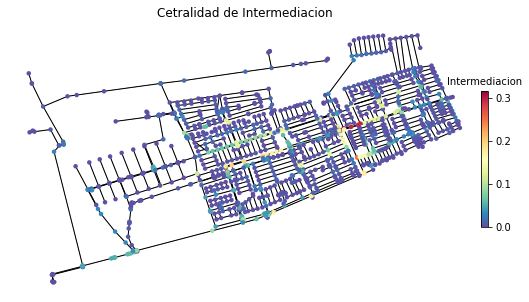

In [16]:
fig, (ax1) = plt.subplots(1, 1, figsize=(10,5))
wntr.graphics.plot_network(wn, title='Cetralidad de Intermediacion', node_attribute='intermediacion', node_colorbar_label='Intermediacion',ax=ax1)

### Excentricidad

In [17]:
eccentricity = nx.eccentricity(uG)


### Centralidad de cercanía

In [18]:
closeness_centrality = nx.closeness_centrality(G)

### Grado de nodo
Cantidad de enlaces que tiene un nodo

Calculamos el grado nodal

In [19]:
node_degree = G.degree()

Agregamos el grado como atributo de los nodos

In [20]:
#itera entre todos los nodos de la red 
for node_name, node in wn.nodes():
    node.grado = node_degree[node_name]

Graficamos la red de acuerdo al grado

(<matplotlib.collections.PathCollection at 0x229d68419a0>,
 <matplotlib.collections.LineCollection at 0x229d6750760>)

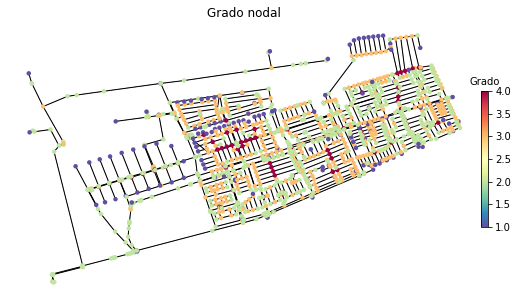

In [21]:
fig, (ax1) = plt.subplots(1, 1, figsize=(10,5))
wntr.graphics.plot_network(wn, title='Grado nodal', node_attribute='grado', node_colorbar_label='Grado',ax=ax1)

### Nodos terminales
Los nodos terminales son los de grado 1 (azules)

In [22]:
terminal_nodes = wntr.metrics.terminal_nodes(G)
print(len(terminal_nodes))

157


### Puntos de articulación

In [23]:
articulation_points = list(nx.articulation_points(uG))

### Puentes

In [24]:
bridges = wntr.metrics.bridges(G)

## Métricas hidráulicas
Requieren de la simulación hidráulica de la red.

In [25]:
wn.options.hydraulic.demand_model = 'PDD'
sim = wntr.sim.WNTRSimulator(wn)
results = sim.run_sim()

Nodos y momentos en los que la presión (pressure) supera (np.greater) un umbral (threshold), utilizando los resultados de una simulación hidráulica.

In [26]:
pressure = results.node['pressure']
threshold = 21.09 # 30 psi
pressure_above_threshold = wntr.metrics.query(pressure, np.greater,threshold)
print (pressure_above_threshold)

          1    10   100   103   1037  1038  1039   104   1040   1042  ...  \
0      True  True  True  True   True  True  True  True   True   True  ...   
3600   True  True  True  True   True  True  True  True   True   True  ...   
7200   True  True  True  True   True  True  True  True   True   True  ...   
10800  True  True  True  True   True  True  True  True   True   True  ...   
14400  True  True  True  True   True  True  True  True   True   True  ...   
18000  True  True  True  True  False  True  True  True  False  False  ...   
21600  True  True  True  True  False  True  True  True  False  False  ...   
25200  True  True  True  True  False  True  True  True  False  False  ...   
28800  True  True  True  True  False  True  True  True  False  False  ...   
32400  True  True  True  True  False  True  True  True  False  False  ...   
36000  True  True  True  True   True  True  True  True   True   True  ...   
39600  True  True  True  True   True  True  True  True   True   True  ...   

La poblacion la calcula como demanda_promedio_esperada / consumo per capita (R). Por default R=8.76157e-06 m3/s, esto se puede cambiar

In [27]:
pop = wntr.metrics.population(wn)
wntr.graphics.plot_interactive_network(wn, node_attribute=pop,node_range=[0,500], filename='population.html', auto_open=True)

### Disponibilidad de servicio de agua
wsa = demanda / demanda esperada. Se puede calcular un promedio o calcular por cada nodo
Si la demanda esperad es cero, el resultado es indefinido (NaN)

In [29]:
expected_demand = wntr.metrics.expected_demand(wn)
demand = results.node['demand']
wsa = wntr.metrics.water_service_availability(expected_demand, demand)
print(wsa)

        1   10  100  103  1037  1038  1039  104  1040  1042  ...  POZO_4  \
0     NaN  1.0  NaN  NaN   1.0   1.0   1.0  NaN   1.0   1.0  ...     NaN   
3600  NaN  1.0  NaN  NaN   1.0   1.0   1.0  NaN   1.0   1.0  ...     NaN   
7200  NaN  1.0  NaN  NaN   1.0   1.0   1.0  NaN   1.0   1.0  ...     NaN   
10800 NaN  1.0  NaN  NaN   1.0   1.0   1.0  NaN   1.0   1.0  ...     NaN   
14400 NaN  1.0  NaN  NaN   1.0   1.0   1.0  NaN   1.0   1.0  ...     NaN   
18000 NaN  1.0  NaN  NaN   1.0   1.0   1.0  NaN   1.0   1.0  ...     NaN   
21600 NaN  1.0  NaN  NaN   1.0   1.0   1.0  NaN   1.0   1.0  ...     NaN   
25200 NaN  1.0  NaN  NaN   1.0   1.0   1.0  NaN   1.0   1.0  ...     NaN   
28800 NaN  1.0  NaN  NaN   1.0   1.0   1.0  NaN   1.0   1.0  ...     NaN   
32400 NaN  1.0  NaN  NaN   1.0   1.0   1.0  NaN   1.0   1.0  ...     NaN   
36000 NaN  1.0  NaN  NaN   1.0   1.0   1.0  NaN   1.0   1.0  ...     NaN   
39600 NaN  1.0  NaN  NaN   1.0   1.0   1.0  NaN   1.0   1.0  ...     NaN   
43200 NaN  1

## Indice de Todini
El resultado se da en distintos momentos de tiempo

In [36]:
head = results.node['head']
pump_flowrate = results.link['flowrate'].loc[:,wn.pump_name_list]
todini = wntr.metrics.todini_index(head, pressure, demand, pump_flowrate, wn,threshold)
print(todini)

0        0.750227
3600     0.751810
7200     0.753340
10800    0.754800
14400    0.766471
18000    0.415395
21600    0.414843
25200    0.414231
28800    0.395831
32400    0.394830
36000    0.704603
39600    0.703722
43200    0.702903
46800    0.702238
50400    0.701382
54000    0.702439
57600    0.416643
61200    0.415318
64800    0.414158
68400    0.413006
72000    0.697799
75600    0.698361
79200    0.699322
82800    0.700475
86400    0.750227
dtype: float64


In [37]:
print(len(todini))

25


In [38]:
print(wn.pump_name_list)

['BOMBA14', 'BOMBA_4', 'BOMBA_6', 'BOMBA_7', 'BOMBA_8', 'BOMBA_1', 'BOMBA_2', 'BOMBA_3', 'BOMBA_9', 'BOMBA13', 'BOMBA_5']
